# Deep Learning course - LAB 8

## Feature Visualization in ConvNets

### Recap from previous Lab

* we learned to build some popular Convolutional Neural Network (CNN) architectyres
* we saw how to implement various techniques of Transfer Learning on CNNs

### Agenda for today

* we will learn about two main staples of Feature Visualization (FV) in CNNs:
    * saliency maps
    * Deep Dream

## Feature Visualization

FV is one of the main tools of Explainable AI (XAI) in CNNs. The aim is to answer the following question: «*What are the (visual) features that are being looked at/searched for by the model for a given image or class?*»

The field of research is wide and a lot of work has been done on this field, yet, there is still so much to learn and the framework is all but unified. The main reference for the works in this field are contained in the e-journal [distill.pub](distill.pub), and namely the articles by Christopher Olah and his group @ OpenAI [1](https://distill.pub/2017/feature-visualization/), who concentrate on analyzing what single neurons or convolutional filters learn in specific CNN architectures and weights configuration. It's a daunting task because you have to scrutinize single neurons or filters in a huge CNN and analyze response to 1+ million images. The results, though, are staggering, and really let us draw considerations on the capability of the network, especially considering the aspect of **generalization**.

Below, a representation of a neuron in a ResNet50 trained on ImageNet, built as an «artificial, optimized image that maximizes activations of the given unit.»

![](img/trump_neurons.jpg)

Image from [OpenAI Microscope](https://microscope.openai.com/models/contrastive_4x/image_block_4_5_Add_6_0/89).

Note: in the same layer, there are 2559 more neurons to analyze...

Note2: all the implementation below have been heavily inspired by [2](https://github.com/utkuozbulak/pytorch-cnn-visualizations). The author did an amazing job by gathering an exhaustive amount of techniques for XAI, but unfortunately the code is not polished, the repo is not a library, and there's a stubborn use of NumPy when torch methods are available nonetheless. If you want, you may fork the library and post a pull request of modernized code

### Saliency Maps

Saliency Maps (SMs) [3] are one of the first example of FV for CNNs. The motivation behind them is to search which pixel of a given image was more *salient* in the classification of an image in a given class $c\in \{1,\dots,C\}$.

To rephrase it, we wish to find an approximation of which part of an image was deemed more important by the CNN relative to the given class $c$.

The intuition behind it is simple: pick an image $I_0$, forward-propagate it through the CNN, then backpropagate the gradient **on the image itself** (NB: we backpropagate on the pixels, not on the weights).

Let us call $M\in\mathbb{R}^{h\times w}$ the SM, and $M_{ij}$ the map for pixel $i, j$.

In the case of a grayscale image $I_0\in\mathbb{R}^{h\times w}$, the SM is:

$M_{ij} = \vert \partial \text{score} / \partial I_0  \vert$

where $\text{score}$ is the prediction of the model.

If we have a multi-channel (e.g. color) image $I_0\in\mathbb{R}^{h\times w\times \text{ch}}$, than the SM is:

$M_{ij} = \max_{\text{ch}}\{\vert \partial \text{score} / \partial I_0  \vert\}$

i.e., for each pixel we select the maximum value between the channels.

#### Implementation

The implementation is simple. We just need to:
* set the model in `eval` mode, to avoid recalculation of batchnorm and application of dropout
* forward propagate the image, remembering to set `requires_grad` to `True`
* backpropagate

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
from torchsummary import summary
import timm
from PIL import Image
from matplotlib import pyplot as plt
from scripts.torch_utils import use_gpu_if_possible

In [2]:
def get_saliency_map(sample, net, category=None):
    '''
    if category is None, saliency is calculated on the predicted category
    '''
    assert len(sample.shape) == 4, f"Expected input tensor of shape (1 x ch x h x w). Found {list(sample.shape)}"
    # 1. set to eval and erase previous gradient
    net.eval()
    net.zero_grad()
    # 2. switch requires_grad for image
    sample.requires_grad = True
    # 3. forward propagate image
    y_hat = net(sample)

    # 4. select category -- if None it is the argmax
    if category is None:
        category = y_hat.argmax().item()
    category_onehot = torch.zeros(y_hat.shape)
    category_onehot[:, category] = 1
    
    # 5. get score and backprop
    y_hat.backward(gradient=category_onehot)

    saliency_map = sample.grad[0].abs()
    # special case -- if image is RGB, I need to do channel-wise max
    if len(sample.shape) == 4 and sample.shape[1] > 1:
        saliency_map = saliency_map.max(dim=0)[0]
    
    # return map normalized in 0-1
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min()) 
    return saliency_map

Let us apply it on a ResNet152D model pre-trained on ImageNet. We will use TIMM API for this pretrained model, since there's not much clarity about the preprocessing phase of images for torchvision pretrained models:
![]()

In [3]:
net = timm.create_model("resnet152d", pretrained=True)
config = timm.data.resolve_data_config({}, model=net)
transform = timm.data.transforms_factory.create_transform(**config)

/home/zullich/miniconda3/envs/lot/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [4]:
transform

Compose(
    Resize(size=256, interpolation=bicubic)
    CenterCrop(size=(256, 256))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Starting from this transform, we implement a helper function to *undo the last two transformations*, i.e. recover an image from the 3d or 4d tensor which PyTorch requires as input to the CNN.

In [5]:
def tensor2img(transform, img):
    if len(img.shape) == 4:
        out = img[0].permute(1,2,0)
    else:
        out = img.permute(1,2,0)
    out.requires_grad = False
    out *= transform.transforms[-1].std
    out += transform.transforms[-1].mean
    out[out>1] = 1
    out[out<0] = 0
    out *= 255
    out = out.numpy().astype("uint8")
    return Image.fromarray(out)

Let us now load an image from the validation set of ImageNet.

In [6]:
img_raw = Image.open("img/ImageNet/ILSVRC2012_img_val/ILSVRC2012_val_00000028.JPEG")
img = transform(img_raw)

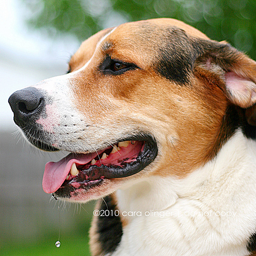

In [7]:
# showcase of tensor2img use
img_cropped = tensor2img(transform, img)
img_cropped

We add an empty dimension to the tensor to be able to feed the image to the CNN. A PyTorch CNN expects the input to be of shape $n\times \text{ch} \times h \times w$, where $n$ is the number of units in the mini-batch.

In [8]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 256, 256])

What is the output class?

In [9]:
net(img).argmax()

tensor(166)

Class 166 corresponds to "Walker hound", while the ground truth is 167 → "English foxhound" (small misclassification error committed by the network)

Let us derive the saliency map.

In [10]:
smap = get_saliency_map(img, net)

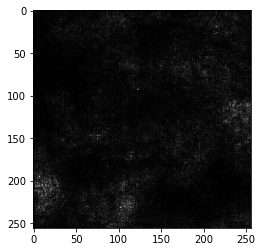

In [11]:
plt.imshow(smap, cmap="gray")

Actually, we may loosely visualize the contours of the hound's face within the map...

We can use `cv2` `addWeighted` function to overlap the two images and have a better feeling about what the saliency map is looking at within the image. We could do it better by further processing the image, but this viz will be fine for our lab.

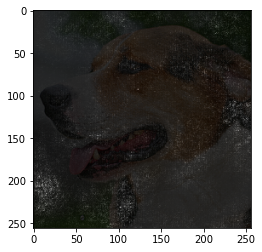

In [13]:
def merge_saliency_and_img(saliency_map, image):
    h, w = smap.shape
    smap_img = cv2.cvtColor((smap * 255).numpy().astype("uint8"), cv2.COLOR_GRAY2RGB)
    img_np = np.array(image)
    plt.imshow(cv2.addWeighted(img_np, .15, smap_img, .85, 0))

merge_saliency_and_img(smap, img_cropped)

Let's try it with a different image, this one representing a *snowmobile*. This time, the model classifies it correctly.

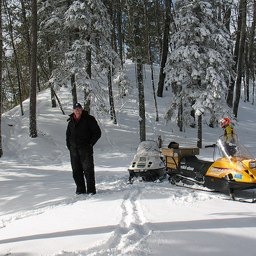

In [14]:
img_raw = Image.open("img/ImageNet/ILSVRC2012_img_val/ILSVRC2012_val_00000131.JPEG")
img = transform(img_raw)
img = img.unsqueeze(0)
img_cropped = tensor2img(transform, img)

smap = get_saliency_map(img, net.cpu())
img_cropped

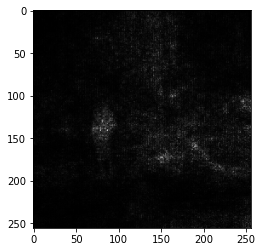

In [15]:
plt.imshow(smap, cmap="gray")

We see that the saliency map is actually pretty focussed on the two snowmobiles: moreover, it looks at the man standing in the picture, plus a small part of the background, though, the maximum concentration seems to be on the two cars.

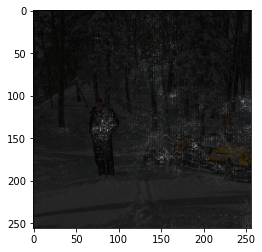

In [16]:
merge_saliency_and_img(smap, img_cropped)

### DeepDream

DeepDream ([4]) is a technique for "visualizing by optimization". Namely, we wish to visualize a channel $\kappa\in\{1,\dots,\text{ch}\}$ from the output a given convolutional layer $l$, and we do it by *tweaking* an input image $I\in\mathbb{R}^{h\times w}$ to maximally activate that channel.

The core concept behind it is easy: we take an image, possibly (but not necessarily) from the train/test set and we forward it through the net until we have reached the layer $l$.

The output of $l$ is $a_l \in \mathbb{R}^{\text{ch} \times h_l\times w_l}$. We wish to maximally activate the $\kappa$-th channel of it. We hence do backpropagation from $a_l^{(\kappa)} \in \mathbb{R}^{h_l\times w_l}$ towards $I$ and we fix the "weights", which in this case are the pixels of $I$.

An additional note: in this task, we wish to maximize the activation $a_l^{(\kappa)}$. The loss function is hence the **negative of the mean activation $a_l^{(\kappa)}$**.

Before introducing the implementation, though, we need to introduce the concept of **forward hook** in PyTorch, which will help us in obtaining an **intermediate activation** without tweaking the existing `forward` method or introducing another ad-hoc routine.

Note that DeepDream does not give us a channel visualization *in absolute terms*, as the activation we maximize is **dependent upon the input image**.

First, let's have a look at the scheme of the network. The network is very deep 

In [17]:
_ = summary(net)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       864
|    └─BatchNorm2d: 2-2                  64
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       9,216
|    └─BatchNorm2d: 2-5                  64
|    └─ReLU: 2-6                         --
|    └─Conv2d: 2-7                       18,432
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-8                   --
|    |    └─Conv2d: 3-1                  4,096
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    |    └─ReLU: 3-6                    --
|    |    └─Conv2d: 3-7                  16,384
|    |    └─BatchNorm2d: 3-8             512
|   

Despite seemingly hard to grasp, the concept behind the forward hooks is simple: we need to create a method with the following signature:

```python
hook_function(nn_module, input_to_module, output_of_module)
```

Inside this `hook_function` we will be doing whatever we need to do to store the activation function. Basically, we don't need the input, but just the output. Since the activation is not present as a keyword argument, we will be storing it in an external list (acting then as a "global" var).

In [18]:
activations = []
def hook_function(module, input_, output):
    activations.append(output)

The function defined as above will be enough to store the activation of any given module.

We now need to tell a given layer to **register a hook** during the forward call.

We can do it by calling `module.register_forward_hook(hook_function)`.

Supposing we wish to store the activation of the first ReLU within the first Bottleneck layer, we must first track the name of this module within our net, then do the registration.

*Tip: to find the names of the layers within a given network, use `net.modules()` and `net.named_modules()` to find the correct name of a module. Note also that `nn.Sequential` stores its modules as a list (so you can access them with `__getitem__`), while normally you access the module as `net.module_name`.*

In [19]:
# this is the given module
net.layer1[0].conv1

Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [20]:
handle = net.layer1[0].conv1.register_forward_hook(hook_function)

We store the output of `register_forward_hook` in a variable, so later we will be able to call `handle.remove()` to remove the hook in case we don't want to use it anymore.

Let us test if the hook works. We will call `forward` on the net...

In [21]:
_ = net(img)
print("Does the image require grad?", img.requires_grad)

Does the image require grad? True


... and see what's now inside `activations`

In [22]:
activations[0].shape

torch.Size([1, 64, 64, 64])

As expected, the output is a 64-channel "image".

We can now remove the handle to start our implementation of DeepDream.

In [23]:
handle.remove()

To execute an optimization **in the input space**, we need to create an optimizer which **acts only on the input**. We don't want to accidentally update the parameters of our model by calling `optimizer.step()`.

Ideally, it'll be like this:
```py
optimizer = torch.optim.SGD([image_to_optimize], lr=12, weight_decay=1e-4)
```

Moreover, we'll ask the user which **module** and **filter** of our net will be visualized.

Eventually, we'll store intermediate representations (*dreams*) of our session to see how the *dream* forms as more and more iteration of the routine are finished.

In [24]:
def deep_dream(image:torch.Tensor, num_ite, net, module, num_filter, optim_fn=lambda img: torch.optim.SGD([img], lr=12, weight_decay=1e-4), ite_interm_store=50, device=None):
    assert len(image.shape) == 4, f"4-d tensor required as image. Found {image.shape}"
    # set up device and send data and model to device
    if device is None:
        device = use_gpu_if_possible()
    net.to(device)

    image = image.to(device)
    # switch requires_grad on so we can backprop gradient to it
    image = torch.autograd.Variable(image, requires_grad=True)

    # set up hook function and register it to given module
    activations = []
    def hook_function(module, input_, output):
        activations.append(output)
    handle = module.register_forward_hook(hook_function)

    # instantiate optimizer with image as params group
    optimizer = optim_fn(image)

    # this list will hold the intermediate and final result
    dreams = []
    for i in range(num_ite):
        # 1. setup: zero gradient and deplete previous activations
        optimizer.zero_grad()
        activations = []

        # 2. do a forward pass to activate the hook(s)
        _ = net(image)

        # 3. retrieve the activation from the newly populated list
        activation = activations[-1][0, num_filter]

        # 4. we want to modify the input s.t. it maximally activate the layer -> minimize the negative activation
        loss = -torch.mean(activation)

        # 5. backpropagate and step to update the input
        loss.backward()
        optimizer.step()

        # 6. store intermediate result and print loss
        if (i+1) % ite_interm_store == 0 or (i+1) == num_ite:
            print(f"Ite {i+1}: loss {loss.item()}")
            dreams.append(image.cpu().clone())
    
    # remove the hook
    handle.remove()
    # clean up GPU memo if used
    net.cpu()
    image.cpu()
    return dreams

We can now try our implementation on our own pretrained `net`. Remember: layers close to the input are expected to recognize low-level features like texture, color, orientation... on the other hand, the closer to the output, the more complicated the feature.

Let's try with something simple...

In [25]:
dreams = deep_dream(transform(img_raw).unsqueeze(0), num_ite=250, net=net, module=net.layer1[0].conv1, num_filter=0)

Ite 50: loss -2.342376470565796
Ite 100: loss -3.058835506439209
Ite 150: loss -3.6104393005371094
Ite 200: loss -4.039647102355957
Ite 250: loss -4.375919342041016


We recall the previously defined `tensor2img` to plot the last iteration of the *dreams*

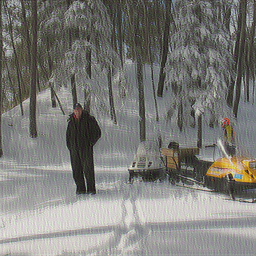

In [26]:
tensor2img(transform, dreams[4].detach())

Provided the CNN supports this (e.g. no tie to the image shape) we may also experiment by passing images with a size different than (224, 224) and not from ImageNet...

In [27]:
cat = Image.open("img/catwide.jpg")
cat = cat.resize((int(1034/2.5), int(652/2.5)), Image.ANTIALIAS) # we reduce a bit the size of the img because we don't want to clog our GPU...
cat_tensor = T.Compose(transform.transforms[2:])(cat).unsqueeze(0)
cat_tensor.shape

torch.Size([1, 3, 260, 413])

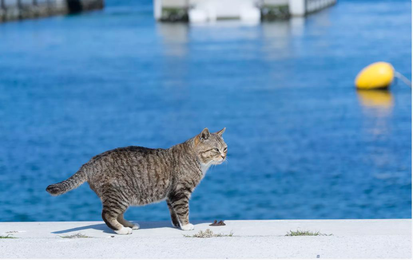

In [28]:
cat

Let us try it on a more advanced layer...

In [37]:
dreams_cat = deep_dream(cat_tensor.clone().detach(), num_ite=250, net=net, module=net.layer3[1].act3, num_filter=333)

Ite 50: loss -18.17831039428711
Ite 100: loss -23.238555908203125
Ite 150: loss -25.638996124267578
Ite 200: loss -27.102787017822266
Ite 250: loss -28.23196792602539


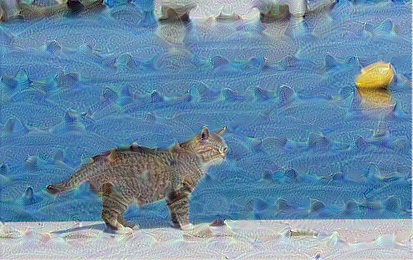

In [38]:
tensor2img(transform, dreams_cat[-1].clone().detach())

Very often, it will be very hard to interpret the *dream*, because the combination of features may be not straightforward as we expected. What is in the image? Are those cat's ears at various positions and with some degree of variation in the orientations? Are those waves?

Let's try with another one...

Ite 50: loss -36.69675064086914
Ite 100: loss -42.77442932128906
Ite 150: loss -45.35279846191406
Ite 200: loss -47.360191345214844
Ite 250: loss -48.8054313659668


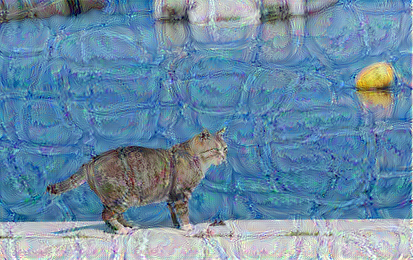

In [44]:
dreams_cat = deep_dream(cat_tensor.clone().detach(), num_ite=250, net=net, module=net.layer3[22].act3, num_filter=74)
tensor2img(transform, dreams_cat[-1].clone().detach())

[1](https://distill.pub/2017/feature-visualization/) warns about the fact that some of these visualization may be misleading:

> If you want to visualize features, you might just optimize an image to make neurons fire. Unfortunately, this doesn’t really work. Instead, you end up with a kind of neural network optical illusion — an image full of noise and nonsensical high-frequency patterns that the network responds strongly to. \[...\]

> If you optimize long enough, you’ll tend to see some of what the neuron genuinely detects as well, but the image is dominated by these high frequency patterns. These patterns seem to be closely related to the phenomenon of adversarial examples.

and

> We don’t fully understand why these high frequency patterns form, but an important part seems to be strided convolutions and pooling operations, which create high-frequency patterns in the gradient 

> These are certainly interesting, but if we want to understand how these models work in real life, we need to somehow move past them… 

#### Consideration on the model

Let us also consider that ResNets are not as straightforward as other "sequential" models, like VGG.

ResNets learn residuals, hence the feature learned may not be as interpretable as those in VGG. Let's try with a pretrained VGG19.

We will use the one from `torchvision`. We actually select only the convolutional part (`features`), discarding the rest since we're not interested in doing predictions with our CNN.

In [45]:
vgg19 = torchvision.models.vgg19(pretrained=True).features

Transforms as of pytorch site:

In [46]:
transform_vgg = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(torch.Tensor([0.485, 0.456, 0.406]), torch.Tensor([0.229, 0.224, 0.225]))
])

Use a copy of our previous image

In [50]:
imgg = transform_vgg(img_raw).unsqueeze(0)

Scheme of the network:

In [59]:
vgg19

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Let us do some tests with increasing level of complexity, as before...

Ite 50: loss -5.499667167663574
Ite 100: loss -7.883842945098877
Ite 150: loss -9.793194770812988
Ite 200: loss -11.492949485778809
Ite 250: loss -13.075374603271484


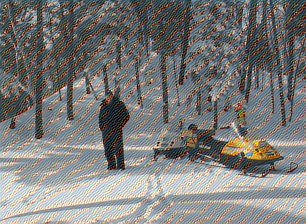

In [58]:
dreams_vgg = deep_dream(imgg.clone(), 250, vgg19, vgg19[8], num_filter=2, ite_interm_store=50)
tensor2img(transform_vgg, dreams_vgg[-1].detach().clone())

Ite 50: loss -31.99805450439453
Ite 100: loss -51.090736389160156
Ite 150: loss -67.49179077148438
Ite 200: loss -82.30427551269531
Ite 250: loss -96.20489501953125


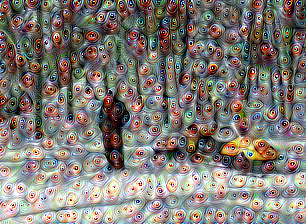

In [51]:
dreams_vgg = deep_dream(imgg.clone(), 250, vgg19, vgg19[17], num_filter=0, ite_interm_store=50)
tensor2img(transform_vgg, dreams_vgg[4].detach().clone())

Ite 10: loss -6.887071132659912
Ite 20: loss -27.31707191467285
Ite 30: loss -55.28365707397461
Ite 40: loss -83.83056640625
Ite 50: loss -110.32072448730469
Ite 60: loss -137.0579833984375


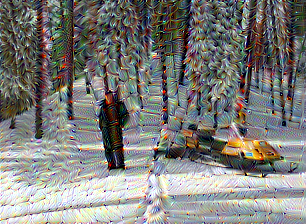

In [82]:
dreams_vgg = deep_dream(imgg.clone(), 60, vgg19, vgg19[23], num_filter=60, ite_interm_store=10)
tensor2img(transform_vgg, dreams_vgg[-1].detach().clone())

The second and third example are very interesting. It'd seem that they are maximally activated by oriented eyes (2) and pine needles or wolf-pelt-like textures oriented in different ways (3).

### Vanilla filter viz

Note: if instead of a regular image we pass a randomly generated image of ~ gray colors, we obtain the **filter visualization** technique instead of DeepDream.

Let us create a random 224x224 RGB image with colors in the interval 150-180.

In [94]:
minval = 150/255 # we normalize in 0-1 because we directly create the tensor instead of passing through the image
maxval = 180/255
randimg = torch.rand((3, 224, 224)) * (maxval - minval) + minval # constrain the output in the 150/255 - 180/255 interval
randimg = transform_vgg.transforms[-1](randimg).unsqueeze(0) # apply the T.Normalize transformation only
randimg.shape

torch.Size([1, 3, 224, 224])

in this case, it's suggested to use Adam with a high learning rate...

In [95]:
optimizer = lambda img: torch.optim.Adam([img], lr=.1, weight_decay=1e-6)

In [100]:
layer_viz = deep_dream(randimg.clone(), 100, vgg19, vgg19[17], num_filter=0, ite_interm_store=25)

Ite 25: loss -7.691874027252197
Ite 50: loss -20.082910537719727
Ite 75: loss -31.240312576293945
Ite 100: loss -41.69773864746094


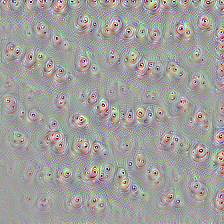

In [101]:
tensor2img(transform_vgg, layer_viz[-1].detach().clone())

we see in this case that the channel viz is actually pretty similar w.r.t. to the "deep-dreamt" one, which suggest that the given filter is **highly specialized towards recognizing eye-like objects**.

See also this other example

![](img/ddream_l17_f0_iter210.jpg)

### Conclusion

There are a lot of FV techniques in the literature. You can categorize them in two broad classes:

1. backprop- and gradient-based techniques, like Saliency Maps
2. optimization-based techniques, like DeepDream and Channel Visualization

If you're interested in doing a review of this field, I would suggest to start from [2](https://github.com/utkuozbulak/pytorch-cnn-visualizations), read the various papers cited there, then move on to [1](https://distill.pub/2017/feature-visualization/) and the following work by OpenAI for the second category of techniques. If you're interesed in applying these techniques in PyTorch, there seem to be a [PT porting of Lucid](https://github.com/greentfrapp/lucent) (which is the original Tensorflow lib developed by Olah's team whose results you may see in their [distill.pub](distill.pub) papers).

References:

[1](https://distill.pub/2017/feature-visualization/) Olah, Cristopher and al. (2017) "Feature Visualization" @ distill.pub → this is the (prologue of the) bible of XAI for what concerns Convolutional Neural Networks. Olah and his team did and are still doing a huge body of work in researching what neurons do and mean in CNNs and what types of neurons there are. Check out their work on [distill.pub](distill.pub).

[2](https://github.com/utkuozbulak/pytorch-cnn-visualizations) PyTorch CNN Visualizations, an extensive collection of XAI techniques for CNNs. Unfortunately, the repo is not a library and would need some amount of modernization in the code, as the application is limited only to `torch.nn.Sequential` modules and there's a stubborn use of NumPy which renders the majority of the techniques unusable with a GPU.

[3](https://arxiv.org/abs/1312.6034) K. Simonyan, A. Vedaldi, A. Zisserman. Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps

[4](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) A. Mordvintsev, C. Olah, M. Tyka. Inceptionism: Going Deeper into Neural Networks 

[5](https://www.researchgate.net/publication/265022827_Visualizing_Higher-Layer_Features_of_a_Deep_Network) D. Erhan, Y. Bengio, A. Courville, P. Vincent. Visualizing Higher-Layer Features of a Deep Network 